In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate
pd.set_option('display.max_columns', None)

print(tf.test.gpu_device_name())

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# List the paths of the CSV files you want to combine
file_paths = ["E:/PhD-CS_Study Stuff_BDALab_PC/Nisha ciciot 2023/data/CICIoT2023/part-00161-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv","E:/PhD-CS_Study Stuff_BDALab_PC/Nisha ciciot 2023/data/CICIoT2023/part-00162-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv","E:/PhD-CS_Study Stuff_BDALab_PC/Nisha ciciot 2023/data/CICIoT2023/part-00163-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"]#,"E:/PhD-CS_Study Stuff_BDALab_PC/Nisha ciciot 2023/data/CICIoT2023/part-00164-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv","E:/PhD-CS_Study Stuff_BDALab_PC/Nisha ciciot 2023/data/CICIoT2023/part-00165-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"]
# Read the CSV files into individual DataFrames
dataframes = [spark.read.csv(file_path, header=True, inferSchema=True) for file_path in file_paths]

# Combine the DataFrames into a single DataFrame
combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.union(df)

# Write the combined DataFrame to a single CSV file
output_path = 'combined_file.csv'
combined_df.coalesce(1).write.csv(output_path, header=True, mode='overwrite')

In [3]:
df = pd.read_csv(r"C:\Users\nvnS\combined_file.csv\part-00000-cfeddc87-2036-48a6-b33e-c15ba1c4a32d-c000.csv")
df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,3.094591,3.094591,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.307698e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SYN_Flood
1,0.001128,6.84,46.24,64.00,12.388567,12.388567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6210.98,587.00,592.00,591.742421,1.102893,589.48,8.367746e+07,9.5,34.401610,1.578947,62.326870,0.02,141.55,Mirai-greeth_flood
2,0.000000,54.00,6.00,64.00,39.854845,39.854845,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.334921e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
3,0.123271,33271.00,17.00,64.00,5487.994090,5487.994090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,525.00,50.00,50.00,50.000000,0.000000,50.00,8.310281e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood
4,0.000000,54.04,6.00,65.91,2.410838,2.410838,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.32,54.00,54.32,54.019781,0.076844,54.04,8.308917e+07,9.5,10.394216,0.108977,0.074513,0.08,141.55,DDoS-SYN_Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905639,0.000000,54.00,6.00,64.00,5.966641,5.966641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.303339e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood
905640,8.547875,20177.97,15.59,68.64,7031.899016,7031.899016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,931.18,50.72,268.64,90.769896,68.440643,82.09,8.334834e+07,9.5,12.897158,96.738630,15977.386269,0.94,141.55,DDoS-RSTFINFlood
905641,0.000000,54.00,6.00,64.00,4.410794,4.410794,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,1.0,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.334818e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
905642,0.000000,0.00,1.00,64.00,22.793830,22.793830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,441.00,42.00,42.00,42.000000,0.000000,42.00,8.314974e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood


In [4]:
df['label'].value_counts()

DDoS-ICMP_Flood            139732
DDoS-UDP_Flood             105060
DDoS-TCP_Flood              87389
DDoS-PSHACK_Flood           79201
DDoS-SYN_Flood              78994
DDoS-RSTFINFlood            78480
DDoS-SynonymousIP_Flood     69927
DoS-UDP_Flood               64254
DoS-TCP_Flood               51456
DoS-SYN_Flood               39515
BenignTraffic               21307
Mirai-greeth_flood          19341
Mirai-udpplain              17216
Mirai-greip_flood           14627
DDoS-ICMP_Fragmentation      8855
MITM-ArpSpoofing             5933
DDoS-ACK_Fragmentation       5557
DDoS-UDP_Fragmentation       5507
DNS_Spoofing                 3548
Recon-HostDiscovery          2594
Recon-OSScan                 1869
Recon-PortScan               1512
DoS-HTTP_Flood               1268
VulnerabilityScan             679
DDoS-HTTP_Flood               583
DDoS-SlowLoris                448
DictionaryBruteForce          279
CommandInjection              112
BrowserHijacking              106
SqlInjection  

In [5]:
#Visualization
def bar_graph(feature):
    df[feature].value_counts().plot(kind="bar")

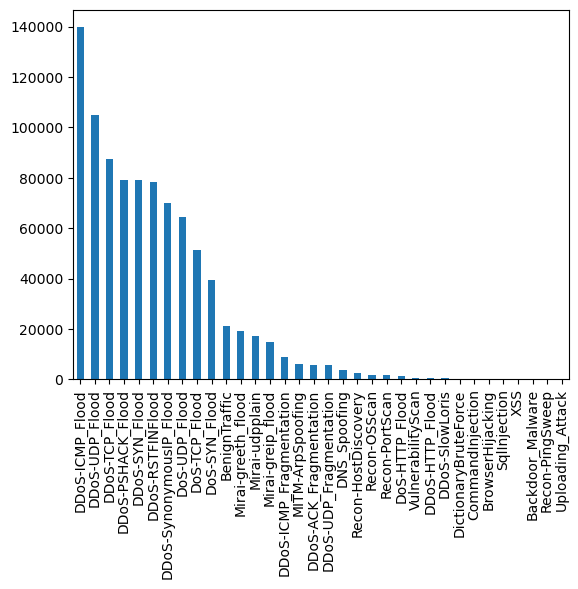

In [6]:
bar_graph('label')

In [7]:
df['label'].unique()

array(['DDoS-SYN_Flood', 'Mirai-greeth_flood', 'DDoS-RSTFINFlood',
       'DDoS-UDP_Flood', 'DDoS-PSHACK_Flood', 'BenignTraffic',
       'DoS-TCP_Flood', 'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Flood',
       'DoS-UDP_Flood', 'DoS-SYN_Flood', 'DDoS-TCP_Flood',
       'DDoS-ACK_Fragmentation', 'DDoS-ICMP_Fragmentation',
       'DDoS-UDP_Fragmentation', 'Recon-HostDiscovery', 'DNS_Spoofing',
       'Mirai-udpplain', 'MITM-ArpSpoofing', 'DoS-HTTP_Flood',
       'Mirai-greip_flood', 'DDoS-SlowLoris', 'XSS', 'Recon-OSScan',
       'VulnerabilityScan', 'DDoS-HTTP_Flood', 'Recon-PortScan',
       'SqlInjection', 'DictionaryBruteForce', 'BrowserHijacking',
       'CommandInjection', 'Backdoor_Malware', 'Uploading_Attack',
       'Recon-PingSweep'], dtype=object)

In [8]:
#encoding categorical data
from sklearn.preprocessing import LabelEncoder

enc=LabelEncoder()
df['label']=enc.fit_transform(df['label'])
df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,3.094591,3.094591,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.307698e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,10
1,0.001128,6.84,46.24,64.00,12.388567,12.388567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6210.98,587.00,592.00,591.742421,1.102893,589.48,8.367746e+07,9.5,34.401610,1.578947,62.326870,0.02,141.55,23
2,0.000000,54.00,6.00,64.00,39.854845,39.854845,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.334921e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,9
3,0.123271,33271.00,17.00,64.00,5487.994090,5487.994090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,525.00,50.00,50.00,50.000000,0.000000,50.00,8.310281e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,14
4,0.000000,54.04,6.00,65.91,2.410838,2.410838,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.32,54.00,54.32,54.019781,0.076844,54.04,8.308917e+07,9.5,10.394216,0.108977,0.074513,0.08,141.55,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905639,0.000000,54.00,6.00,64.00,5.966641,5.966641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.303339e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,13
905640,8.547875,20177.97,15.59,68.64,7031.899016,7031.899016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,931.18,50.72,268.64,90.769896,68.440643,82.09,8.334834e+07,9.5,12.897158,96.738630,15977.386269,0.94,141.55,9
905641,0.000000,54.00,6.00,64.00,4.410794,4.410794,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,1.0,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.00,54.000000,0.000000,54.00,8.334818e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,9
905642,0.000000,0.00,1.00,64.00,22.793830,22.793830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,441.00,42.00,42.00,42.000000,0.000000,42.00,8.314974e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,6


In [9]:
x=df.drop(columns=['label'])
y=df['label']

In [10]:
y

0         10
1         23
2          9
3         14
4         10
          ..
905639    13
905640     9
905641     9
905642     6
905643    19
Name: label, Length: 905644, dtype: int32

In [11]:
#splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [12]:
print("Training set:", len(x_train))
print("Testing set:", len(x_test))

Training set: 724515
Testing set: 181129


In [13]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [14]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(x_train,y_train)

log_acc=clf.score(x_test,y_test)
pred=clf.predict(x_test)

log_prec=precision_score(y_test,pred,average='weighted')
log_rec=recall_score(y_test,pred,average='weighted')
log_f1=f1_score(y_test,pred,average='weighted')

print('accuracy:',log_acc)
print('precision:', log_prec)
print('recall: ', log_rec)
print('f1: ', log_f1)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.8011858951355112
precision: 0.8071246138767073
recall:  0.8011858951355112
f1:  0.766324808195416


In [15]:
from sklearn.ensemble import RandomForestClassifier
clf1=RandomForestClassifier(n_estimators=100)
clf1.fit(x_train,y_train)
rf_acc=clf1.score(x_test,y_test)
pred=clf1.predict(x_test)

rf_prec=precision_score(y_test,pred,average='weighted')
rf_rec=recall_score(y_test,pred,average='weighted')
rf_f1=f1_score(y_test,pred,average='weighted')

print('accuracy:',rf_acc)
print('precision:', rf_prec)
print('recall: ', rf_rec)
print('f1: ', rf_f1)

accuracy: 0.9931043620844813
precision: 0.9927386130977973
recall:  0.9931043620844813
f1:  0.9925662218729598


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from sklearn.ensemble import AdaBoostClassifier

clf2=AdaBoostClassifier()
clf2.fit(x_train,y_train)
ada_acc=clf2.score(x_test,y_test)
pred=clf2.predict(x_test)

ada_prec=precision_score(y_test,pred,average='weighted')
ada_rec=recall_score(y_test,pred,average='weighted')
ada_f1=f1_score(y_test,pred,average='weighted')

print('accuracy:',ada_acc)
print('precision:', ada_prec)
print('recall: ', ada_rec)
print('f1: ', ada_f1)

accuracy: 0.6667678836630246
precision: 0.6426821844551115
recall:  0.6667678836630246
f1:  0.5966402407293454


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
clf3=GradientBoostingClassifier()
clf3.fit(x_train,y_train)
print('accuracy', clf3.score(x_test,y_test))

pred=clf3.predict(x_test)

print('precision: ', precision_score(y_test,pred,average='weighted'))
print('recall: ', recall_score(y_test,pred,average='weighted'))
print('f1:', f1_score(y_test,pred,average='weighted'))

accuracy 0.9858184255729189
precision:  0.9861669104580681
recall:  0.9858184255729189
f1: 0.9856663439882749


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# neural network

In [17]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout,SimpleRNN,Input,GRU
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.utils.np_utils import to_categorical


In [18]:
Y = to_categorical(y)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
#splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.2, random_state = 42, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(724515, 46)
(724515, 34)
(181129, 46)
(181129, 34)


In [20]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [21]:

input_=Input(shape=(x_train.shape[1],))
d=Dense(100, activation='relu')(input_)
d=Dense(100, activation='relu') (d)
d=Dense(100, activation='relu') (d)
d=Dense(100, activation='relu') (d)
d=Dense(100, activation='relu') (d)
d=Dense(100, activation='relu') (d)
output = Dense(34, activation='softmax')(d)

model = Model(inputs=input_, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46)]              0         
                                                                 
 dense (Dense)               (None, 100)               4700      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100 

In [22]:
#callbacks: checkpoint, csv_logger
filepath="nn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
csv_log=CSVLogger('nn_log.csv',separator=',',append=False)
callbacks_list=[checkpoint,csv_log]

history=model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/20
9053/9057 [============================>.] - ETA: 0s - loss: 0.4141 - accuracy: 0.8216
Epoch 1: val_accuracy improved from -inf to 0.88238, saving model to nn.hdf5
9057/9057 [==============================] - 17s 2ms/step - loss: 0.4140 - accuracy: 0.8216 - val_loss: 0.2753 - val_accuracy: 0.8824
Epoch 2/20
9052/9057 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9347
Epoch 2: val_accuracy improved from 0.88238 to 0.95626, saving model to nn.hdf5
9057/9057 [==============================] - 15s 2ms/step - loss: 0.1699 - accuracy: 0.9347 - val_loss: 0.1175 - val_accuracy: 0.9563
Epoch 3/20
9056/9057 [============================>.] - ETA: 0s - loss: 0.1134 - accuracy: 0.9568
Epoch 3: val_accuracy improved from 0.95626 to 0.96351, saving model to nn.hdf5
9057/9057 [==============================] - 15s 2ms/step - loss: 0.1134 - accuracy: 0.9568 - val_loss: 0.0983 - val_accuracy: 0.9635
Epoch 4/20
9035/9057 [============================>.] - ETA: 0s - l

Text(0, 0.5, 'accuracy')

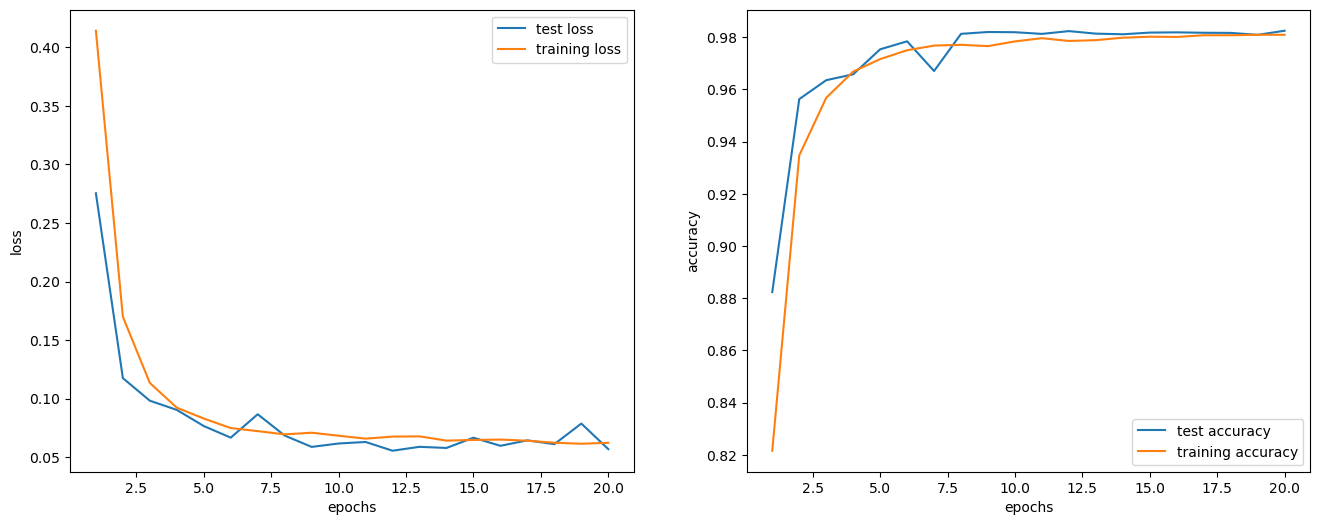

In [23]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(np.arange(1,21,1),history.history['val_loss'], label='test loss')
plt.plot(np.arange(1,21,1),history.history['loss'], label='training loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(np.arange(1,21,1),history.history['val_accuracy'], label='test accuracy')
plt.plot(np.arange(1,21,1),history.history['accuracy'], label='training accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [24]:
#load the best model
dnn=load_model('nn.hdf5')

#getting the probabilities
pred=dnn.predict(x_test)
pred
dnn_pred=pred.argmax(axis=1)
y_test1=y_test.argmax(axis=1)
accuracy_score(y_test.argmax(axis=1),pred.argmax(axis=1))
print('Precision score: ',precision_score(y_test1, dnn_pred, average='weighted'))
print('Recall score: ',recall_score(y_test1, dnn_pred,average='weighted'))
print('F1 score: ',f1_score(y_test1, dnn_pred,average='weighted'))

5661/5661 [==============================] - 5s 843us/step
Precision score:  0.9800217734687782
Recall score:  0.9825262658105549
F1 score:  0.980354844276757


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
